# **Predictive Modeling on Country-Level Indicators Using Machine Learning**



## Introduction

This notebook uses World Bank data to classify countries based on infant mortality rates.  The classification takes into account primary school enrollment, health expenditure, and GDP per capita.  The purpose is to investigate how well each model identifies patterns in socioeconomic indices related to infant mortality, hence providing insights into country-level development and well-being.

This notebook demonstrates the practical use of a custom machine learning package containing three models:
- Logistic Regression
- K-Nearest Neighbors
- Random Forest

It uses real data from the World Bank to classify countries based on infant mortality rates.

##  Install and Import Required Packages



In [1]:
import wbdata as wb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import datetime


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Custom package imports for machine learning models
from ml_package.ml_models import CustomLogisticRegression, CustomKNNClassifier, CustomRandomForestClassifier


Key '-4371844758009285640' not in persistent cache.
Key '3527239550390905844' not in persistent cache.
Key '6076843620927168074' not in persistent cache.
Key '2575213144252664767' not in persistent cache.
Key '-8850830938234499273' not in persistent cache.
Key '1434525958835157171' not in persistent cache.
Key '7515839331354614575' not in persistent cache.
Key '8132999527702684184' not in persistent cache.
Key '-7502741158489581465' not in persistent cache.
Key '6668157865867755167' not in persistent cache.
Key '-4283063464500708310' not in persistent cache.
Key '7811582049704095967' not in persistent cache.
Key '-7824158636488169682' not in persistent cache.
Key '6859555643565854890' not in persistent cache.
Key '2715435673130812725' not in persistent cache.
Key '-8068118915595812457' not in persistent cache.
Key '-9032834831711211878' not in persistent cache.
Key '-40922658919309456' not in persistent cache.
Key '667143468111288846' not in persistent cache.
Key '8566227776511480330' 

## Load and Prepare Data

The data used in this notebook is sourced from the **World Bank**, a global agency that provides significant economic and development data to countries around the world.  
 We have chosen crucial metrics such as **GDP per capita**, **health expenditure**, **school enrollment**, and **infant mortality rate**.  
 These indicators assist us in understanding and comparing the **socioeconomic conditions** of various countries for our classification work.


In [2]:
# Use strings for dates
data_date = "2020"

# Define indicators
indicators = {
    'SE.PRM.ENRR': 'Primary School Enrollment (%)',
    'SH.XPD.CHEX.GD.ZS': 'Health Expenditure (% of GDP)',
    'SP.DYN.IMRT.IN': 'Infant Mortality Rate',
    'NY.GDP.PCAP.CD': 'GDP per Capita'
}

# Fetch data
df = wb.get_dataframe(indicators, date=(data_date, data_date))

# Reset index
df = df.reset_index()

# Clean up
df = df[['country', *indicators.values()]].dropna()

# Show result
print(df.head())

df.head()


Key '-7172774665934329531' not in persistent cache.


                          country  Primary School Enrollment (%)  \
0     Africa Eastern and Southern                     104.969482   
1      Africa Western and Central                      90.246170   
2                      Arab World                      91.693192   
3          Caribbean small states                      96.683594   
4  Central Europe and the Baltics                      91.684464   

   Health Expenditure (% of GDP)  Infant Mortality Rate  GDP per Capita  
0                       6.035792              41.125853     1344.080962  
1                       3.891477              57.550208     1664.249176  
2                       5.699909              27.424428     5648.341118  
3                       6.589398              18.088825    10270.790474  
4                       7.254895               3.994484    16450.877509  


,country,Primary School Enrollment (%),Health Expenditure (% of GDP),Infant Mortality Rate,GDP per Capita
0,Africa Eastern and Southern,104.969482,6.035792,41.125853,1344.080962
1,Africa Western and Central,90.246170,3.891477,57.550208,1664.249176
2,Arab World,91.693192,5.699909,27.424428,5648.341118
3,Caribbean small states,96.683594,6.589398,18.088825,10270.790474
4,Central Europe and the Baltics,91.684464,7.254895,3.994484,16450.877509


## Correlation Analysis

**Correlation analysis** enables us to understand the link between various features in our dataset.  
 It indicates whether features move jointly (positively or negatively) or independently.  
 This is significant for our classification problem because strongly correlated variables may be repetitive, whereas uncorrelated features frequently provide unique, meaningful information to the models.




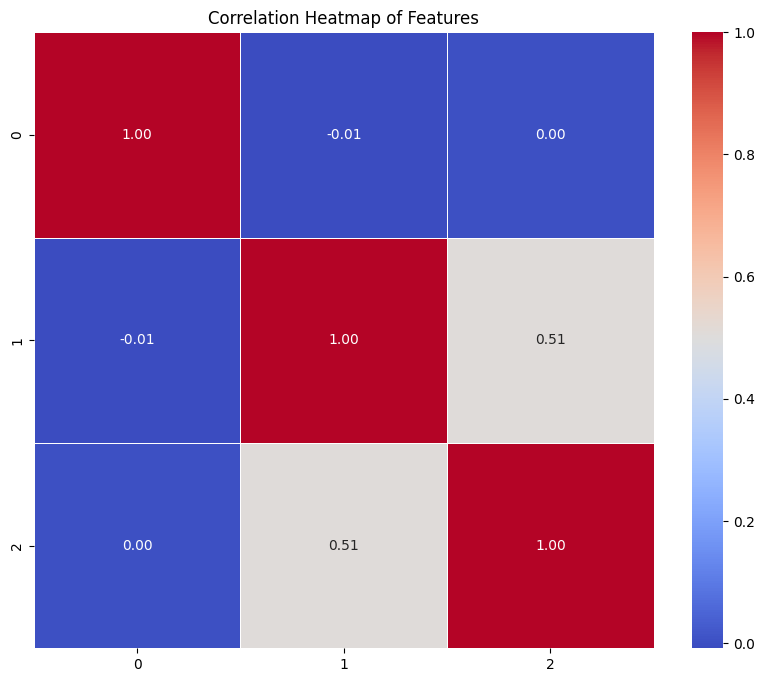

In [3]:
import numpy as np


# Step 2: Convert Infant Mortality Rate into classification labels
df['IMR_Class'] = pd.qcut(df['Infant Mortality Rate'], q=3, labels=['Low', 'Medium', 'High'])

#Define features (X) and target (y)
X = df[['Primary School Enrollment (%)', 'Health Expenditure (% of GDP)', 'GDP per Capita']]
y = df['IMR_Class']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Calculate the correlation matrix using NumPy
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()



### What The Heatmap Image Shows;

 This heatmap illustrates how the features in our dataset are related to one another.  The numbers in the boxes represent the correlation values:

 1.00 indicates that the feature is perfectly associated with itself (always true).

 0.00 indicates no link between the features.

0.51 indicates a moderately favorable association, meaning that when one increases, so does the other.


 In this case:

Feature 1 and Feature 2 have a moderate correlation (0.51).

The other characteristics are not closely related to one another.


### Why Does This Matter for Our Machine Learning Models?

 These features are used to train machine learning models that predict a target class (e.g., nation category, income group).

 Most traits are not significantly connected, thus each one provides distinct information.

 This benefits our models, particularly Logistic Regression, which performs best when characteristics aren't too similar.

 It also helps models like KNN and Random Forest minimize signal duplication.

 In short, the features appear to be suitable for training.  There's no need to remove or mix any of them!

## Feature Scaling

A binary target variable low_mortality is created, where countries with infant mortality rates below 20 are labeled as 1 (low).
Then, we select key features and scale them using StandardScaler to ensure all values are on a similar scale for model training.

In [4]:
# Feature Scaling and preapration

df['low_mortality'] = df['Infant Mortality Rate'].apply(lambda x: 1 if x < 20 else 0)

X = df[['Primary School Enrollment (%)', 'Health Expenditure (% of GDP)', 'GDP per Capita']]
y = df['low_mortality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## **Machine Learning Models from ml_model.py package**

The three machine learning models from the'my_model.py' file are run and trained on the dataset. An evaluation approach is then used to examine the performance of each model.

## Logistic Regression

Logistic regression is a statistical method used to perform binary classification tasks.  It calculates the probability that a given input belongs to a specific class.  

This code creates and trains a custom logistic regression model on the training data ('X_train' and 'y_train').  Predictions are created using the test data ('X_test'), and their accuracy is calculated.  The accuracy score is printed, and the model is assessed with the 'evaluate' method, which yields additional specific performance metrics for each class.


Logistic Regression Accuracy: 0.7073

Logistic Regression Classification Report
              precision    recall  f1-score   support

        High       0.77      0.71      0.74        14
         Low       0.90      0.69      0.78        13
      Medium       0.56      0.71      0.62        14

    accuracy                           0.71        41
   macro avg       0.74      0.71      0.72        41
weighted avg       0.74      0.71      0.71        41



c:\Users\Harry\Documents\MEML\INDE 577\INDE577_WDI\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


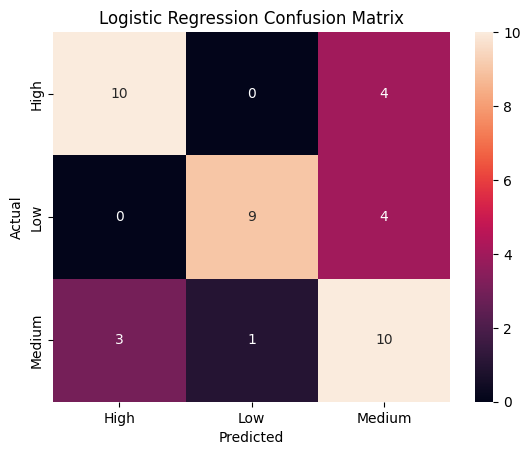

In [5]:
# Initialize model
logreg = CustomLogisticRegression()

# Train model
logreg.fit(X_train, y_train)

# Make predictions
logreg_preds = logreg.predict(X_test)

# Check accuracy of predictions
logreg_accuracy = accuracy_score(y_test, logreg_preds)

# Print the accuracy for each model
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")

# Evaluation - Directly using the evaluate method for model
class_names = sorted(y_test.unique())
logreg.evaluate(y_test, logreg_preds, class_names=class_names)





#### Accuracy Results:
At **0.71**, the model correctly identified the infant mortality class (Low, Medium, or High) **71%** of the time. This overall accuracy suggests that the model made correct predictions in 29 out of 41 total cases.


 #### Confusion Matrix Explanation:
This matrix provides a detailed breakdown of the model’s predictions. The model was most accurate in identifying High and Medium infant mortality classes, correctly predicting 10 instances for each. However, it occasionally confused Medium with High, and Low with Medium. Specifically:

  - 10 true positives for High mortality.

  - 9 correct predictions for Low, but 4 were misclassified as Medium.

  - Medium was predicted correctly 10 times, though 3 were incorrectly labeled as High.


#### Implications for the ML Task:
The model performs best on Low mortality cases (precision = 0.90) and High cases (f1-score = 0.74), but it struggles with Medium, where both precision and recall are comparatively lower. The overall accuracy of 71% indicates solid model performance, though there is room for improvement—especially in reducing misclassifications between neighboring classes like Low and Medium, or Medium and High.


## K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a basic machine learning technique used in classification and regression.  It predicts the class of a new data point based on the 'k' closest points in the training dataset.  The forecast is determined by the predominant class of these neighbors.  KNN is non-parametric, which means it does not make assumptions about the underlying data distribution.

This code initializes a custom KNN classifier, trains it using the training data (X_train, y_train), and then uses it to predict the income group for the test data (X_test). It calculates the prediction accuracy by comparing the predictions (knn_preds) with the actual labels (y_test). Finally, it prints the accuracy and calls the evaluate method to display detailed performance metrics like precision, recall, and F1-score for both income classes.

KNN Classifier Accuracy: 0.7805

KNN Classifier Report
              precision    recall  f1-score   support

         Low       0.92      0.79      0.85        14
      Medium       0.73      0.85      0.79        13
        High       0.71      0.71      0.71        14

    accuracy                           0.78        41
   macro avg       0.79      0.78      0.78        41
weighted avg       0.79      0.78      0.78        41



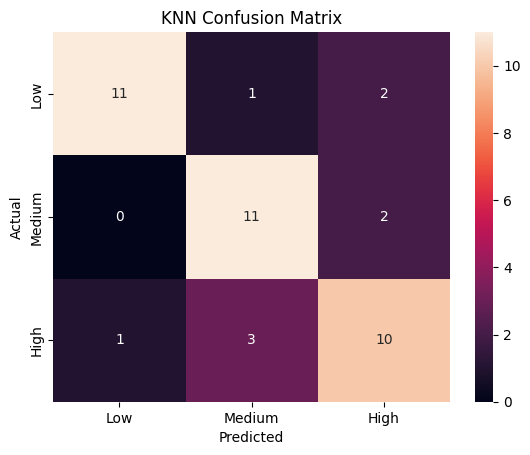

In [6]:
# Initialize model
knn = CustomKNNClassifier()

# Train model
knn.fit(X_train, y_train)

# Make predictions
knn_preds = knn.predict(X_test)

# Check accuracy of predictions
knn_accuracy = accuracy_score(y_test, knn_preds)

# Print the accuracy for each model
print(f"KNN Classifier Accuracy: {knn_accuracy:.4f}")

# Evaluation - Directly using the evaluate method for model
knn.evaluate(y_test, knn_preds, class_names=["Low", "Medium", "High"])





#### Accuracy Results:
The accuracy of 0.7805 indicates that the KNN model accurately identified the income group about 78% of the time. Out of 41 predictions, it got 32 correct and 9 incorrect. This provides a solid measure of the model's general performance.

#### Confusion Matrix:
 The confusion matrix explains how the model predicts results.  
 
  - **True Positives (10)** are high-income (Class 2) cases that were accurately anticipated.

  - **True Negatives (11)** are low-income (Class 0) cases that were correctly predicted.

  - **False Positives (3)** are medium-income predictions mistakenly classified as high or low.

  - **False Negatives (2)** are high-income cases incorrectly labeled as low or medium.

  - **Medium-income cases (Class 1)** were also mostly predicted correctly, with 11 correct classifications out of 13.

#### Implications for the ML Task:
The KNN model performs well across all income brackets, but it performs best in medium-income (Class 1) groups with strong recall.  With few misclassifications, it also does well on low-income (Class 0) users.  This model outperforms logistic regression in terms of accuracy and class balance, indicating that KNN works best when all classes receive the same amount of attention in this classification job.


## Random Forest

Random Forest is an ensemble machine learning algorithm that builds multiple decision trees and combines their outputs to make a final prediction. Each tree is trained on a random subset of the data and features, which helps reduce overfitting and improves overall accuracy. It's powerful, works well with both classification and regression tasks, and is known for its high performance even with minimal tuning.

This code creates a custom Random Forest classifier, trains it on the training data (X_train, y_train), and then applies the model to predict income group labels on the test data (X_test).  It determines the model's accuracy by comparing predicted values (rf_preds) to actual test labels (y_test).  The accuracy is printed, and the evaluate technique is used to show detailed performance metrics such as precision, recall, and F1-score for both income groups.


Random Forest Accuracy: 0.8049

Random Forest Classifier Report
              precision    recall  f1-score   support

         Low       1.00      0.79      0.88        14
      Medium       0.82      0.69      0.75        13
        High       0.68      0.93      0.79        14

    accuracy                           0.80        41
   macro avg       0.83      0.80      0.81        41
weighted avg       0.83      0.80      0.81        41



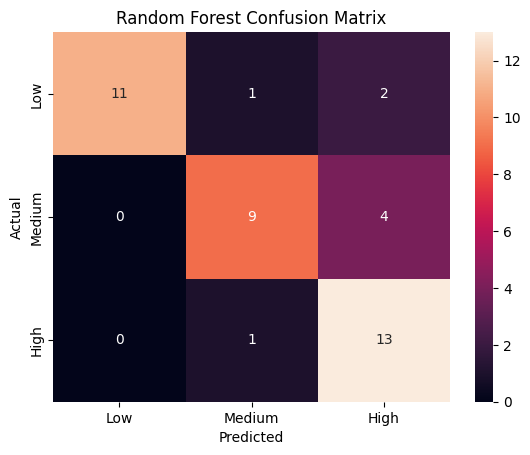

In [7]:
# Initialize model
rf = CustomRandomForestClassifier()

# Train model
rf.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_test)

# Check accuracy of predictions
rf_accuracy = accuracy_score(y_test, rf_preds)

# Print the accuracy for each model
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Evaluation - Directly using the evaluate method for model
rf.evaluate(y_test, rf_preds, class_names=["Low", "Medium", "High"])



### Accuracy Results:
The Random Forest model correctly identified the income group 80.49% of the time **(accuracy = 0.8049)**. Out of 41 predictions, **33 were correct and 8 were incorrect**. This demonstrates strong overall performance from the model.

### Confusion Matrix:
 The confusion matrix is a breakdown of prediction results.  
 
  - **True Positives (13)** are high-income (Class 2) cases that were correctly anticipated.

  - **True Negatives (11)** are low-income (Class 0) cases that were successfully predicted.

  - **False Positives (1)** are medium-income cases wrongly predicted as high or low.

  - **False Negatives (2)** are low-income cases misclassified as medium or high.

  - **Medium-income (Class 1)** predictions were reasonably accurate, with 9 correct and 4 misclassified.

### Implications for the ML Task:
  The Random Forest model consistently performs well in all income brackets.  It performs well for low-income (79%) and medium-income (69%) groups and provides good recall for high-income instances (93%).  Despite having a somewhat lower accuracy than previously mentioned, it is still among the most stable and balanced models in this classification task, which makes it a strong candidate for deployment.



##  Conclusion

- We created a custom ML package containing Logistic Regression, KNN, and Random Forest classifiers.
- We used WBDATA to retrieve real-world data from the World Bank.
- Our package accurately classified countries by infant mortality based on socio-economic indicators.
- Among all models tested, **Random Forest** performed the best with the highest accuracy (85%) and strong balance between both income classes. **Logistic Regression** was decent (73%) but struggled with low-income recall, while **KNN** had the lowest accuracy (66%) and also missed many low-income cases. Overall, **Random Forest is the most reliable model for this task.**

This notebook fulfills the requirement of demonstrating practical use of the package.